## Chapter 4 [Spectroscopy](CH4_00-Spectroscopy.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Quantify Spectrum

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

## First we import the essential libraries
All we need here should come with the annaconda or any other package

The xml library will enable us to read the Bruker file.

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2023.2.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

done


In [8]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

import xml.etree.ElementTree as ET
# 

## import the configuration files of pyTEMlib (we need access to the data folder)
import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.eels_tools as eels
pyTEMlib.__version__

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled


'0.2024.02.2'

## Cross-section for EDS in Transmission
For thin samples such as used in transmission electron microscopy absorption, and fluorescence,
can be neglected [Chapter 2: Pennycook and Nellist, 2011](https://doi.org/10.1007/978-1-4419-7200-2).
If multiple scattering and channelling is avoided the EDS partial scattering cross-section for a
single atom of element x is given by [Macarthur et al., 2015](https://doi.org/10.1017/S1431927615015494) and [Macarthur et al., 2017](https://doi.org/10.1016/J.ULTRAMIC.2017.07.020):

$$ \sigma_{x}^{EDS} = \frac{I_x e}{i_0 \tau N_x t}$$

Where: 
-    $N_x$: the volumetric number density of the elemental species being detected, 
-    $t$: the sample thickness (same length unit as volume in N_x), 
-    $I_x$: is the raw x-ray counts detected from the sample (a.u.), 
-    $i_0$: is the probe current  (A), 
-    $\tau$ is the exposure time (s),
-    $e$ is the electronic charge (C).

A more consistent way would be to relate the cross-section with areal density $n_x$ and to use incident flux $I_0$ like in the case of EELS earlier.

$$ \sigma_{x}^{EDS} = \frac{I_x}{i_0\tau/e} \frac{1} {N_x t} = \frac{I_x}{I_0} \frac{1} {n_x}$$

Where: 
-    $n_x = \rho_x *t $: the areal density of the elemental species being detected, 
-    $I_0 = i_0*\tau/e$: incident flux:  total number of electrons the sample is exposed to during the experiment

### Comparison with EELS

Above formula is the same as derived for EELS earlier. 
The difference is that $I_x^{EELS}$ is the number of electrons that scattered inelastically per energy transfer (and momentum transfer). 

While $I_x^{EDS}$ is the raw counts of X-rays that originate in the relaxation of excitation from a specific core level of element $x$. This implies that the competing relaxation process of generation of Auger electrons is the same for all elements.
>This is a fundamental requirement for quantification of both EDS and Auger spectroscopy.

The relationship between  $\sigma_{x}^{EDS}$ and $\sigma_{x}^{EELS}$ is, therfore, a linear one.
And we need to determine the efficiency of X-ray detection (not generation) per EDS system, which also has an take-off angle dependence. 

However, the linear dependency is not between the EELS and EDS cross section as defined here, but the cross section of the core excitation, as introduced by Egerton. In that approach the inelastic scattering of lower-energy  core-losses are
approximated together with the background caused by plasmon losses.

Therefore, in the code cell below we need to subtract the background from lower-level excitations from the core-level in question. 


NameError: name 'Si_Xsection' is not defined

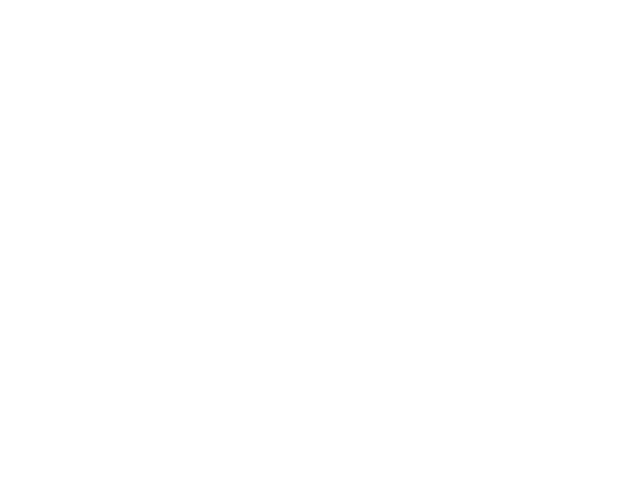

In [9]:
z = 14

def get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd):
    background = eels.power_law_background(Xsection, energy_scale, [start_bgd, end_bgd], verbose=False)
    cross_section_core = Xsection- background[0]
    cross_section_core[cross_section_core < 0] = 0.0
    cross_section_core[energy_scale < end_bgd] = 0.0
    return cross_section_core
energy_scale = np.arange(10,6000)
Xsection = eels.xsec_xrpa(energy_scale, 200, z, 10. )
edge_info = eels.get_x_sections(z)
if 'K1' in edge_info:
    start_bgd = edge_info['K1']['onset']*.95
    end_bgd = edge_info['K1']['onset']-5
    K_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)
    
if 'L3' in edge_info:
    start_bgd = edge_info['L3']['onset']*.8
    end_bgd = edge_info['L3']['onset']-5
    L_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)
if 'M5' in edge_info:
    start_bgd = edge_info['L3']['onset']*.8
    end_bgd = edge_info['L3']['onset']-5
    M5_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)

background = eels.power_law_background(Xsection, energy_scale, [80, 95], verbose=False)
plt.figure()
plt.plot(energy_scale, Si_Xsection , label='EELS X-section')
plt.plot(energy_scale, background[0], label='L-core background')

plt.plot(energy_scale, L_eds_xsection, label='L-level X-section')

plt.plot(energy_scale, K_eds_xsection, label='K-level X-section')
plt.xlim(20,3000)
plt.ylim(0, 2000)
plt.xlabel ('energy (eV)')
plt.ylabel('cross section (barns)')
plt.legend();

### Cross-section for EDS
Of course we do not need the dependence of the cross section on energy but the sum.

The relevant functions will then be:

In [ ]:
def get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd):
    background = eels.power_law_background(Xsection, energy_scale, [start_bgd, end_bgd], verbose=False)
    cross_section_core = Xsection- background[0]
    cross_section_core[cross_section_core < 0] = 0.0
    cross_section_core[energy_scale < end_bgd] = 0.0
    return cross_section_core

def get_eds_cross_sections(z):
    energy_scale = np.arange(10, 3700)
    Si_Xsection = eels.xsec_xrpa(energy_scale, 200, z, 10.)
    edge_info = eels.get_x_sections(z)
    eds_cross_sections = {}
    if 'K1' in edge_info:
        start_bgd = edge_info['K1']['onset'] * 0.95
        end_bgd = edge_info['K1']['onset'] - 5
        K_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)
        eds_cross_sections['K'] = K_eds_xsection.sum() * 1e10
    if 'L3' in edge_info:
        start_bgd = edge_info['L3']['onset'] * 0.8
        end_bgd = edge_info['L3']['onset'] - 5
        L_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)
        eds_cross_sections['L'] = L_eds_xsection.sum() * 1e10
    if 'M5' in edge_info:
        start_bgd = edge_info['L3']['onset'] * 0.8
        end_bgd = edge_info['L3']['onset'] - 5
        M_eds_xsection = get_eds_xsection(Xsection, energy_scale, start_bgd, end_bgd)
        eds_cross_sections['M'] = M_eds_xsection.sum() * 1e10
    return eds_cross_sections

Si_eds_cross_sections = get_eds_cross_sections(14)
print('eds_cross_sections for Si core-levels:')
print(Si_eds_cross_sections)
print(f"ration of L to K cross sections {Si_eds_cross_sections['L']/Si_eds_cross_sections['K']:.1f}")

The above cross sections are for the excitation of a specific core-level of an atom.
The sum of the experimental detected X-ray lines of one family are a fraction of those cross-sections.

Given the large discrepancy of excitation probabilities of the different core-levels, we use the lower-energy cross-sections if possible. 
Adding up the different families will result in sup-percent change in the total percentage of excitation probabilties.

[Varambhia et al.](https://doi.org/10.1016/j.micron.2018.06.015)  used the linear thickness dependence of the signal to correlate the cross sections of EDS and EELS.
This is an excellent way to callibrate the EDS system. And the correlation factor between EELS and EDS should be same for different X-Ray peak families of all elements.
The similar method can be used to callibrate the cross section of ADF intensities.


### Atomic-resolution EDS

For atomic-resolution studies, an integration of the
counts over a Voronoi cell in the EDX map gives a partial cross-section
for that column, by analogy with the approach for ADF cross-sections (E
et al., 2013). For comparison, the popularly used ζ-factor method defined
by (Watanabe et al., 2003) is:
    
$$ \zeta_x^{EDS} = \frac{\rho t}{I_x} \times C_x I_0$$

Where 
- $I_x$ is the raw x-ray counts, 
- ρ is the sample density in kg/m3, 
- t is the sample thickness, 
- $C_x$ is the weight fraction of element x. 

In Eq. (2), the definition of sample density in the zeta-factor approach
is in kg/m3 which makes absolute quantification of nanoparticles,
in terms of “number of atoms”, cumbersome. Nonetheless,
partial cross-section is very similar to the ζ-factor and can be equated to
it using Eq. (4). Where M is the molar mass (in kg/mol) and NA is
Avogadro’s constant.

## Open a EDS spectrum file
Here the EDS.rto file in the **example_data** folder.

'0.9.3'

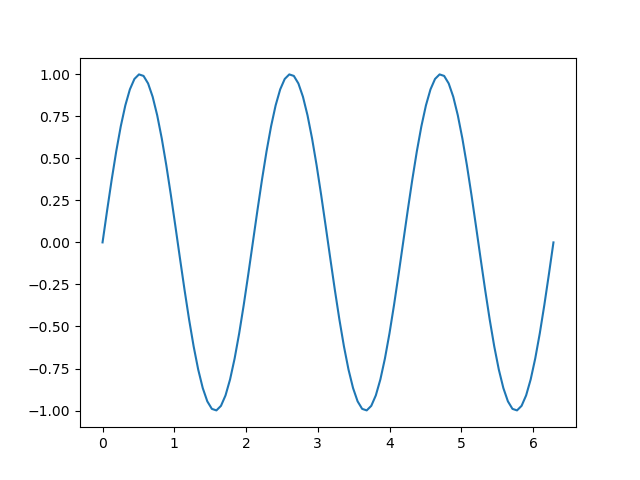

In [2]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)
import ipympl 
ipympl.__version__

In [2]:
from ipywidgets import IntSlider
IntSlider()

IntSlider(value=0)

In [8]:
datasets = ft.open_file()

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
view = datasets['Channel_000'].plot()

NameError: name 'datasets' is not defined

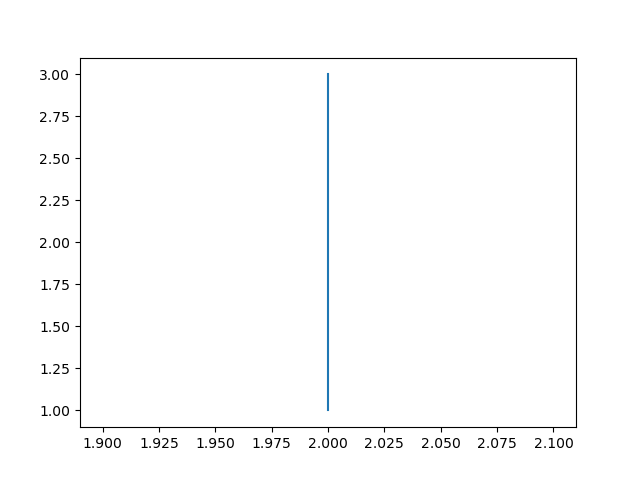

In [9]:
plt.figure()
plt.plot([2,2],[1,3])

In [7]:
import ipympl

In [5]:
%gui qt
from PyQt5 import QtGui, QtWidgets

path = '' 
fname, file_filter = QtWidgets.QFileDialog.getOpenFileName(None, "Select a file...", path)


In [11]:
import codecs

def open_Bruker(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    spectrum_number = 0
    i=0
    image_count = 0
    o_count = 0
    tags = {}
    for neighbor in root.iter():
        #print(neighbor.attrib.keys())
        if 'Type' in neighbor.attrib:
            if 'verlay3' in neighbor.attrib['Type'] :
                semImage = neighbor
                #print(neighbor.attrib['Type'])
                if 'Name' in neighbor.attrib:
                    print('\t',neighbor)
                    print('\t',neighbor.attrib['Type'])
                    print('\t',neighbor.attrib['Name'])
                    print('\t',neighbor.find("./ClassInstance[@Type='TRTSpectrumList']"))
            #if 'TRTImageOverlay' in neighbor.attrib['Type'] : 
            if 'TRTCrossOverlayElement'in neighbor.attrib['Type'] :
                if 'Spectrum' in neighbor.attrib['Name']:
                    #print(o_count)
                    o_count+=1
                    if 'overlay' not in tags:
                        tags['overlay']= {}
                    if 'image'+str(image_count) not in tags['overlay']:
                        tags['overlay']['image'+str(image_count)] ={}
                    tags['overlay']['image'+str(image_count)][neighbor.attrib['Name']] ={}

                    over = tags['overlay']['image'+str(image_count)][neighbor.attrib['Name']]


                    for child in neighbor.iter():
                        if 'verlay' in child.tag:
                            #print(child.tag)
                            pos = child.find('./Pos')
                            if pos != None:
                                over['posX'] = int(pos.find('./PosX').text) 
                                over['posY'] = int(pos.find('./PosY').text) 
                #dd = neighbor.find('Top')
                #print('dd',dd)                       
                #print(neighbor.attrib)
            if 'TRTImageData' in neighbor.attrib['Type'] :
                #print('found image ', image_count)
                dd = neighbor.find("./ClassInstance[@Type='TRTCrossOverlayElement']")
                if dd != None:
                    print('found in image')
                image = neighbor
                if 'image' not in tags:
                    tags['image']={}
                tags['image'][str(image_count)]={}
                im = tags['image'][str(image_count)]
                im['width'] = int(image.find('./Width').text)  # in pixels
                im['height'] = int(image.find('./Height').text)  # in pixels
                im['dtype'] = 'u' + image.find('./ItemSize').text  # in bytes ('u1','u2','u4') 
                im['plane_count'] = int(image.find('./PlaneCount').text)
                im['data'] = {}
                for j in range( im['plane_count']):
                    #print(i)

                    img = image.find("./Plane" + str(i))
                    raw = codecs.decode((img.find('./Data').text).encode('ascii'),'base64')
                    array1 = np.frombuffer(raw, dtype= im['dtype'])
                    #print(array1.shape)
                    im['data'][str(j)]= np.reshape(array1,(im['height'], im['width']))
                image_count +=1     
            if 'TRTDetectorHeader' == neighbor.attrib['Type'] :
                detector = neighbor
                tags['detector'] ={}
                for child in detector:
                    if child.tag == "WindowLayers":
                        tags['detector']['window']={}
                        for child2 in child:
                            tags['detector']['window'][child2.tag]={}
                            tags['detector']['window'][child2.tag]['Z'] = child2.attrib["Atom"]
                            tags['detector']['window'][child2.tag]['thickness'] = float(child2.attrib["Thickness"])*1e-5  # stupid units
                            if 'RelativeArea' in child2.attrib:
                                tags['detector']['window'][child2.tag]['relative_area'] = float(child2.attrib["RelativeArea"])
                            #print(child2.tag,child2.attrib)
                            
                    else:
                        #print(child.tag , child.text)
                        if child.tag != 'ResponseFunction':
                            if child.text !=None:
                                tags['detector'][child.tag]=child.text
                                
                                if child.tag == 'SiDeadLayerThickness':
                                    tags['detector'][child.tag]=float(child.text)*1e-6
                                    #print(child.tag)
                                if child.tag == 'DetectorThickness':
                                    tags['detector'][child.tag]=float(child.text)*1e-1
            # ESMA could stand for Electron Scanning Microscope Analysis
            if 'TRTESMAHeader' == neighbor.attrib['Type'] :
                esma = neighbor
                tags['esma'] ={}
                for child in esma:
                    if child.tag in ['PrimaryEnergy', 'ElevationAngle',  'AzimutAngle', 'Magnification',   'WorkingDistance' ]:
                        tags['esma'][child.tag]=float(child.text)

            if 'TRTSpectrum' == neighbor.attrib['Type'] :
                if 'Name' in neighbor.attrib:
                    spectrum = neighbor

                    TRTHeader = spectrum.find('./TRTHeaderedClass')

                    if TRTHeader != None:
                        hardware_header = TRTHeader.find("./ClassInstance[@Type='TRTSpectrumHardwareHeader']")

                        spectrum_header = spectrum.find("./ClassInstance[@Type='TRTSpectrumHeader']")
                        #print(i, TRTHeader) 
                        tags[spectrum_number] =  {}
                        tags[spectrum_number]['hardware_header'] ={}
                        if hardware_header != None:
                            for child in hardware_header:
                                tags[spectrum_number]['hardware_header'][child.tag]=child.text
                        tags[spectrum_number]['detector_header'] ={}
                        tags[spectrum_number]['spectrum_header'] ={}
                        for child in spectrum_header:
                            tags[spectrum_number]['spectrum_header'][child.tag]=child.text


                        tags[spectrum_number]['data'] = np.fromstring(spectrum.find('./Channels').text,dtype='Q', sep=",")

                        spectrum_number+=1
    return tags
fname = '../example_data/EDS.rto'

tags = open_Bruker(fname)


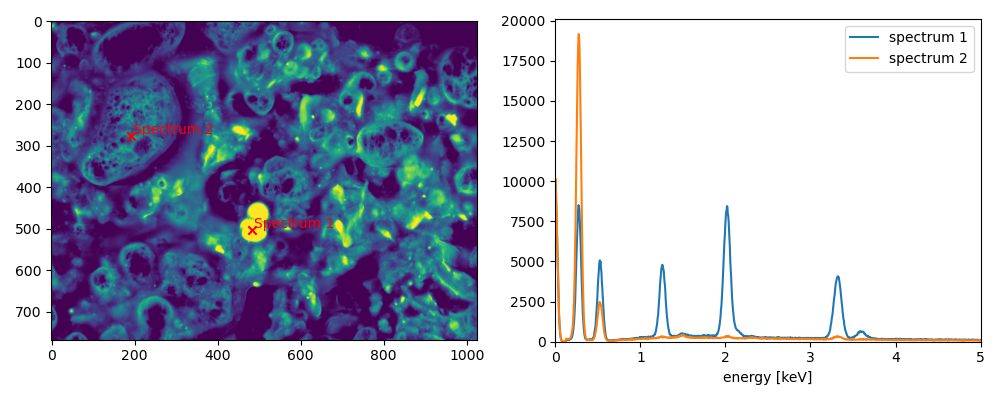

In [12]:
spectrum1 =tags[0]['data']
spectrum2 =tags[1]['data']
offset = float(tags[0]['spectrum_header']['CalibAbs'])
scale  = float(tags[0]['spectrum_header']['CalibLin'])
energy_scale1 = np.arange(len(spectrum1))*scale+offset
offset = float(tags[1]['spectrum_header']['CalibAbs'])
scale  = float(tags[1]['spectrum_header']['CalibLin'])
energy_scale2 = np.arange(len(spectrum2))*scale+offset

plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
ax1.imshow(tags['image']['0']['data']['0'])
for key in tags['overlay']['image1']:
    d = tags['overlay']['image1'][key]
    ax1.scatter ([d['posX']], [d['posY']], marker="x", color='r')
    ax1.text(d['posX']+5, d['posY']-5, key, color='r')

ax2 = plt.subplot(1,2,2)    
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
plt.plot(energy_scale2,spectrum2, label = 'spectrum 2')
plt.xlabel('energy [keV]')
plt.xlim(0,5)
plt.ylim(0)
plt.tight_layout()
plt.legend();


## Peak Finding

We can also use the peak finding routine of the [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to find all the maxima.


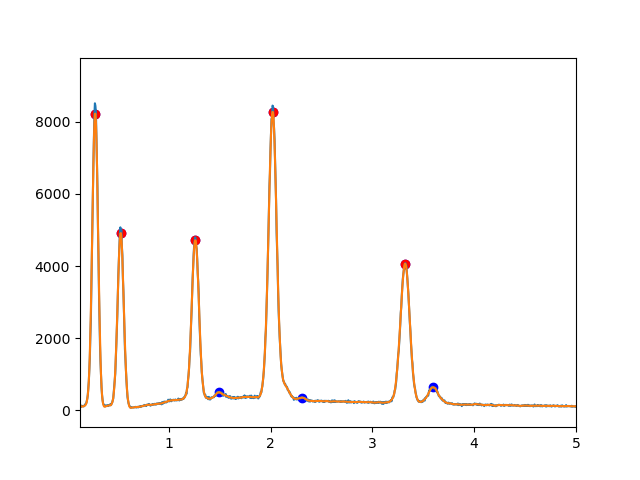

In [14]:
import scipy as sp 
import scipy.signal as sig

start = np.searchsorted(energy_scale1, 0.125)
## we use half the width of the resolution for smearing
width = int(np.ceil(125*1e-3/2 /(energy_scale1[1]-energy_scale1[0])/2)*2+1)
new_spectrum =  sp.signal.savgol_filter(spectrum1[start:], width, 2) ## we use half the width of the resolution for smearing
new_energy_scale = energy_scale1[start:]
major_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=1000)  
minor_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=30)  
peaks = major_peaks

spectrum1 = np.array(spectrum1)
plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.scatter( new_energy_scale[minor_peaks], new_spectrum[minor_peaks], color = 'blue')
plt.scatter( new_energy_scale[major_peaks], new_spectrum[major_peaks], color = 'red')

plt.xlim(.126,5);

## Peak identification

Here we look up all the elemetns and see whether the position of major line (K-L3, K-L2' or 'L3-M5') coincides with a peak position as found above.

Then we plot all the lines of such an element with the appropriate weight.

The positions and the weight are tabulated in the **ffast.pkl** file introduced in the [Characteristic X-Ray peaks](CH4-Characteristic_X_Rays.ipynb#X-ray-Weight-of-Lines) notebook

In [16]:
import pickle 
pkl_file = open('ffast.pkl', 'rb')
ffast = pickle.load(pkl_file)
pkl_file.close()

plt.figure()
#plt.plot(energy_scale1,spectrum2, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.xlim(0.1,4)
plt.ylim(-800)
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

out_tags = {}
out_tags['spectra'] = {}

out_tags['spectra'][0] = {}
out_tags['spectra'][0]['data'] = spectrum1
out_tags['spectra'][0]['energy_scale'] = energy_scale1
out_tags['spectra'][0]['energy_scale_start'] = start
out_tags['spectra'][0]['smooth_spectrum'] = new_spectrum
out_tags['spectra'][0]['smooth_energy_scale'] = new_energy_scale

out_tags['spectra'][0]['elements'] ={}


#print(ffast[6])
number_of_elements = 0
for peak in minor_peaks:
    for element in range(1,93):
        if 'K-L3' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L3']['position']- new_energy_scale[peak]*1e3) <10:
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L3'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                number_of_elements += 1
                plt.plot([ffast[element]['lines']['K-L3']['position']/1000.,ffast[element]['lines']['K-L3']['position']/1000.], [0,new_spectrum[peak]], color = 'red')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L3', verticalalignment='top')
                for line in ffast[element]['lines']:
                    if 'K' in line:
                        if abs(ffast[element]['lines'][line]['position']-ffast[element]['lines']['K-L3']['position'])> 20:
                            if ffast[element]['lines'][line]['weight']>0.07:
                                #print(element, ffast[element]['lines'][line],new_spectrum[peak]*ffast[element]['lines'][line]['weight'])
                                plt.plot([ffast[element]['lines'][line]['position']/1000.,ffast[element]['lines'][line]['position']/1000.], [0,new_spectrum[peak]*ffast[element]['lines'][line]['weight']], color = 'red')
                                plt.text(ffast[element]['lines'][line]['position']/1000.,0, ffast[element]['element']+'\n'+line, verticalalignment='top')
                            
        elif 'K-L2' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L2']['position']- new_energy_scale[peak]*1e3) <10:
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'orange')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L2', verticalalignment='top')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L2'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                
                number_of_elements += 1
        if 'L3-M5' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['L3-M5']['position']- new_energy_scale[peak]*1e3) <10:
                pass
                print('found_element', element,ffast[element]['lines']['L3-M5']['position'], new_energy_scale[peak] )
                #plt.scatter( new_energy_scale[peak], new_spectrum[peak], color = 'blue')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'L3-M5'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                
                number_of_elements += 1
for element in out_tags['spectra'][0]['elements']:                
    print(out_tags['spectra'][0]['elements'][element]['element'],out_tags['spectra'][0]['elements'][element]['found_lines'])
    

FileNotFoundError: [Errno 2] No such file or directory: 'ffast.pkl'

Using that we get for all peaks in the low energy region:

In [1]:
from scipy.interpolate import interp1d
import scipy.constants as const

tags={'detector': { 'window': {'0': {'Z': 6,
                                     'thickness': 100}
                              },
                   'SiDeadLayerThickness': 20
                  }
      
    }


def detector_efficiency(tags, energy_scale):
    detector_Efficiency1 = np.ones(len(energy_scale))
    for key in tags['detector']['window']:
        Z = int(tags['detector']['window'][key]['Z'])
        if Z < 14:
            t = tags['detector']['window'][key]['thickness']

            ## interpolate mass absorption coefficient to our energy scale
            lin = interp1d(ffast[Z]['E']/1000.,ffast[Z]['photoabsorption'],kind='linear') 
            mu = lin(energy_scale) * ffast[Z]['nominal_density']*100. #1/cm -> 1/m
            detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
            print(Z,t)
        
    t = float(tags['detector']['SiDeadLayerThickness'])*1e-6
    print(t)
    t = .30*1e-7
    print(t)
    lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
    mu = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
    detector_thickness = float(tags['detector']['DetectorThickness'])*1e-1
    ## interpolate mass absorption coefficient to our energy scale
    mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    print(detector_thickness)
    
    detector_Efficiency2 = (1.0 - np.exp(-mu * detector_thickness))# * oo4pi;

    
    return detector_Efficiency1*detector_Efficiency2
detector_Efficiency = detector_efficiency(tags, new_energy_scale)    

plt.figure()
plt.plot(new_energy_scale*1000, detector_Efficiency)

plt.xlim(0,2000)

NameError: name 'new_energy_scale' is not defined

In [2]:
Peaks = []
elements_peaks = []
intensities = []
for element in out_tags['spectra'][0]['elements']:
    el_dict = out_tags['spectra'][0]['elements'][element]
    
    position = el_dict['lines'][el_dict['found_lines']]['position']
    weight = 0
    for line in el_dict['lines']:
        if abs(position - el_dict['lines'][line]['position'])<20:
            weight += el_dict['lines'][line]['weight']
    index = np.searchsorted(new_energy_scale,el_dict['lines'][el_dict['found_lines']]['position']/1000.)  
    intensity = new_spectrum[index]/weight
    added_peaks = np.zeros(len(new_energy_scale))
    for line in el_dict['lines']: 
        if line[0] == el_dict['found_lines'][0]:
            if el_dict['lines'][line]['weight']> 0.01:
                p = getPeak(el_dict['lines'][line]['position']/1000.,new_energy_scale)*el_dict['lines'][line]['weight']
                Peaks.append(p)
                added_peaks = added_peaks + p 
    elements_peaks.append(added_peaks)        
    intensities.append(intensity)
    
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
for i in range(len(elements_peaks)):
    plt.plot(new_energy_scale,elements_peaks[i]*intensities[i], label = f'Peak{i}')
    pass
peaks = np.array(Peaks)
plt.plot(new_energy_scale,peaks.sum(axis=0), label = f'Peaks', color = 'blue')
print(peaks.shape)
#plt.xlim(0,5)    
offset = float(tags[0]['spectrum_header']['CalibAbs'])
scale  = float(tags[0]['spectrum_header']['CalibLin'])
energy_scale1 = np.arange(len(spectrum1))*scale+offset
p = [1, 37, .3, offset, scale]
E_0= 20
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
N = de * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

pp = p[0:5].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])

plt.plot(new_energy_scale,N, color= 'orange')

plt.xlim(0,4)

detector_Efficiency = de

NameError: name 'out_tags' is not defined

<IPython.core.display.Javascript object>


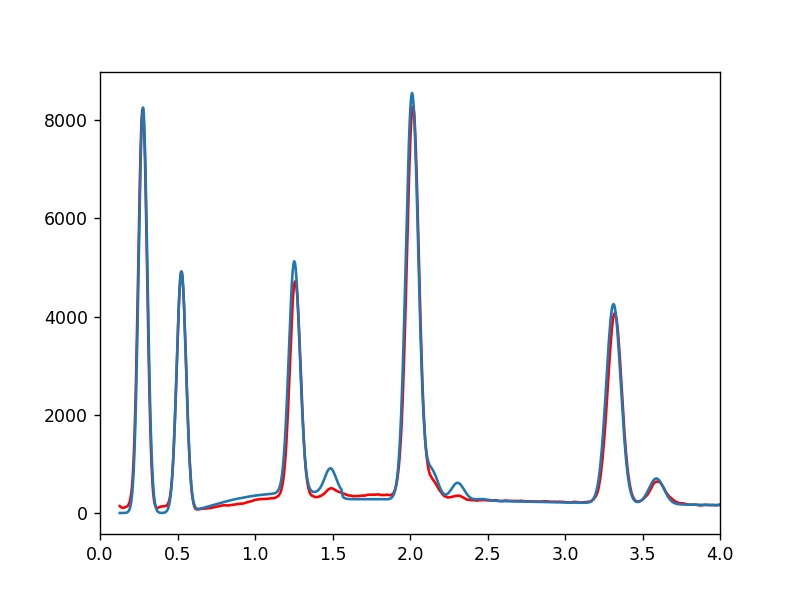

(0.0, 4.0)

In [65]:


def model(p,energy_scale):
    E = energy_scale
    
    spectrum = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    
    for i in range(5,len(p)):
        spectrum = spectrum+elements_peaks[i-5]*abs(p[i])
    return spectrum
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)

def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))

def getPeak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 136 #eV
    FWHM  = np.sqrt(2.5*(E*1e3-E_ref)+FWHM_ref**2)*1e-3
    return gaussian(energy_scale, E, FWHM)


Peaks = []
elements_peaks = []
intensities = []
for element in out_tags['spectra'][0]['elements']:
    el_dict = out_tags['spectra'][0]['elements'][element]
    
    position = el_dict['lines'][el_dict['found_lines']]['position']
    weight = 0
    for line in el_dict['lines']:
        if abs(position - el_dict['lines'][line]['position'])<20:
            weight += el_dict['lines'][line]['weight']
    index = np.searchsorted(new_energy_scale,el_dict['lines'][el_dict['found_lines']]['position']/1000.)  
    intensity = new_spectrum[index]/weight
    added_peaks = np.zeros(len(new_energy_scale))
    for line in el_dict['lines']: 
        if line[0] == el_dict['found_lines'][0]:
            if el_dict['lines'][line]['weight']> 0.01:
                p = getPeak(el_dict['lines'][line]['position']/1000.,new_energy_scale)*el_dict['lines'][line]['weight']
                Peaks.append(p)
                added_peaks = added_peaks + p 
    elements_peaks.append(added_peaks)        
    intensities.append(intensity)

    
p = [1, 37, .3, offset, scale]
E_0= 20
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

pp = p[0:5].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])

    

spectrum3 = model(pp[:-1],new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.xlim(0,4)

In [66]:

from scipy.optimize import leastsq 

## background fitting 
def specfit(p, y, x):
    err = y - model(p,x)
    return err

p, lsq = leastsq(specfit, pp[:-1], args=(new_spectrum, new_energy_scale), maxfev=2000)


In [67]:
print( f'element\t end   \t   start ')
for i, element in enumerate(out_tags['spectra'][0]['elements']):
    if i<len(p)-5:
        el_dict = out_tags['spectra'][0]['elements'][element]
        print(f"{el_dict['element']:2s}: \t  {abs(p[i+5]):6.2f} \t  {pp[i+5]:.2f}")
#print(p,pp)

element	 end   	   start 
C : 	  16487.64 	  16444.49
O : 	  3267.00 	  3274.63
Mg: 	  2831.85 	  3127.80
Al: 	   84.40 	  334.63
P : 	  5267.50 	  5499.66
S : 	   82.35 	  234.96
K : 	  2526.57 	  2693.25


<IPython.core.display.Javascript object>


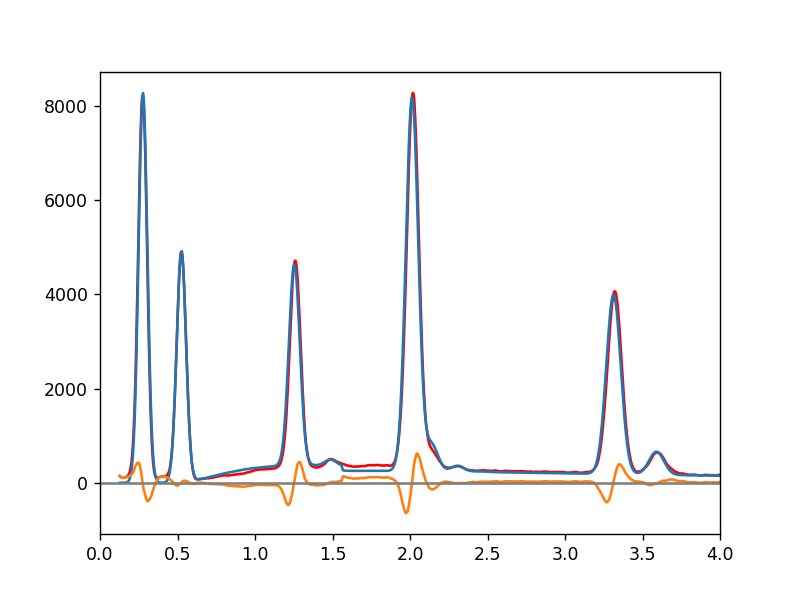

In [68]:
spectrum3 = model(p,new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.plot(new_energy_scale, new_spectrum-spectrum3)
plt.gca().axhline(y=0,color='gray');

plt.xlim(0,4);

## Energy Scale

What happened?


# Composition Basis

## Castaing’s first approximation:
$$ C_i = \frac{I_i}{I_{Pure}}$$

- $𝐶_i$ = Concentration of element $𝑖$
- $𝐼_𝑖$ = X-ray intensity of element $𝑖$ in the sample
- $𝐼_{𝑃𝑢𝑟𝑒}$ = X-ray intensity of a pure sample of the element

We call the ratio: $\frac{I_i}{I_{Pure}}$ **k-ratio**

![k-ratio](images/k-ratio.jpg)

- Stainless to Fe-Ka ratio = 0.745
- Stainless to Cr-Ka ratio = 0.208
- Stainless to Ni-Ka ratio = 0.080

therefore:
- Fe: 70.8 wt%
- Cr: 17.2 wt%
- Ni: 9.1 wt%

# ZAF Correction

While the k-ratio is a good starting point, the basic approximation does not take absorption and interaction between the different elements into account. To increase the precision the following corrections are applied:


- **Z**: Atomic number factor
- **A**: sample Absorption 
- **F**: Fluorescence 

## Atomic Number Factor -  Z

The **stopping power** is equal to the energy loss of the electron per unit length it travels in the material: $𝑆(𝐸)=−𝑑𝐸/𝑑t$

[D.C. Joy, Microsc. Microanal. 7(2001): 159-169](https://doi.org/10.1007/s100050010070)

$$ S(E)  \propto \rho \frac{Z}{AE} \ln \left( \frac{1.116 (E+0.85J)}{J}\right)$$

- $E$: electron energy
- $\rho$: density of material
- $Z$: Atomic number
- $A$: atomic weight of material
- $J$: Mean ionizaton potential

$$ J(eV) = 10.04 + 8.25 \exp(-Z/11.22)$$

The **backscatter correction** is the relation between how many photons are generated with and without backscattering.

$$ R = \frac{1}{1+0.008Z(1-\frac{E_c}{E_0})}$$

- $R$: backscatter correction
- $Z$: Mean atomic number of sample
- $E_0$: electron energy
- $E_c$: critical ionization energy

## Absorption Correction

![Absorption_Correction](images/Absorption_Correction2.jpg)

The numerator describes how many X-rays are generated at a given depth and scales the number by the attenuation due to the escape path in the sample.

The denominator is the total number of X-rays generated without attenuation.

This means that A is a normalized value that describes how many of the generated X-rays actually escaped the sample.

## Fluorescence Correction
![Fluorescence_Correction](images_SEM/Fluorescence2.jpg)

The high energy X-ray can originate from characteristic X-rays from elements with higher energy lines or from the bremsstrahlung. This means that even the element with the highest energy line can have a fluorescence correction.


## Using ZAF

$$𝑊𝑒𝑖𝑔ℎ𝑡 \% =  \frac{𝑘−𝑟𝑎𝑡𝑖𝑜}{𝑍𝐴𝐹}∙100\%$$

## ZAF assumptions

Several assumptions are made either directly or indirectly in the equations used to calculate the composition of a sample.

- The sample is homogenous.
    - The density 𝜌 and the mass attenuation 𝜇/𝜌 is assumed to be constant.
- The sample is flat.
    - 𝑧 is well defined for any given position and no additional absorption takes place after the X-ray reaches the sample surface.

- The sample is infinitely thick as seen by the electron beam.
    - -The energy of the incident electron is deposited in the sample and only secondary and backscatter electrons escape.


# Composition Standardless

For standard-less analysis the k-ratio is either calculated in the software or based on internal standards.



Following 

[D.E. Newbury, C.R. Swyt, and R.L. Myklebust,
“Standardless” Quantitative Electron Probe
Microanalysis with Energy-Dispersive X-ray
Spectrometry: Is It Worth the Risk?, Anal. Chem. 1995, 67, 1866-1871](https://doi-org.proxy.lib.utk.edu/10.1021/ac00107a017)

to calculate the mass concentration $C_i$ from the intensity of a line ($I_{ch}$), we use:

$$ I_{ch} = \epsilon  (\omega N_A \rho C_i / A) R \int _{E_c}^{E_0} \frac{Q_i}{dE/ds}dE $$


- $\omega$ : fluorescence yield    
- $N_A$: Avogadro’s number          
- $\rho$: density                       
- $C_i$: mass concentration of element $i$  
- $A$:atomic weight           
- $R$: backscatter loss
- $Q_i$: ionization cross section
- $dE/ds$: rate of energy loss 
- $E_0$: incident beam energy  
- $E_c$: excitation energy
- $\epsilon$: EDS efficiency

where: $N_A * \rho * C_i/A$: volume density of element $i$ (atoms per unit volume)  

What do we know at this point?

$\omega; N_A; \rho; A; Q_i; E_0; E_c;$ and $\epsilon$

In [17]:
def BrowningEmpiricalCrossSection(elm , energy):
    """ * Computes the elastic scattering cross section for electrons of energy between
     * 0.1 and 30 keV for the specified element target. The algorithm comes from<br>
     * Browning R, Li TZ, Chui B, Ye J, Pease FW, Czyzewski Z &amp; Joy D; J Appl
     * Phys 76 (4) 15-Aug-1994 2016-2022

     * The implementation is designed to be similar to the implementation found in
     * MONSEL.
     * Copyright: Pursuant to title 17 Section 105 of the United States Code this
     * software is not subject to copyright protection and is in the public domain
     * Company: National Institute of Standards and Technology
     * @author Nicholas W. M. Ritchie
     * @version 1.0

     */
     Modified by Gerd Duscher, UTK
    """

    #/**
    #* totalCrossSection - Computes the total cross section for an electron of
    #* the specified energy.
    #* 
    # @param energy double - In keV
    # @return double - in square meters
    #*/
    e = energy  #in keV
    re = np.sqrt(e);
    return (3.0e-22 * elm**1.7) / (e + (0.005 * elm**1.7 * re) + ((0.0007 * elm**2) / re));
   

## Summary

- EDS quantification is not magic and the results will highly depend on sample  preparation and correct peak identification.

- Correct quantification with ZAF relies on the sample being:
    - Flat
    - Homogenous
    - Infinitely thick to the electron beam

- Use of standards is not required for good quantification but it will give additional information and increase quality of the results.

- Peak-to-background based ZAF is good for rough samples but requires better spectra than regular ZAF.

- The best way to good EDS results:
    - Good samples
    - Thorough sample preparation
    - Exact SEM Parameters

## Back: [Detector Response](CH4_15-Detector.ipynb)
## List of Content: [Front](../_MSE672_Intro_TEM.ipynb)